# Klasyfikacja za pomocą sieci konwolucyjnych

## Import bibliotek i wczytanie danych

Do treningu wykorzystuję zbiór danych **fashion_mnist** zawierający 70000 zdjęć ubrań. Każde zdjęcie jest reprezentowane jako tablica 28x28 pikseli w odcieniach szarości. Każdy piksel przyjmuje wartość od 0-255.

Zbiór treningowy to 60000 cyfr, a testowy 10000.

In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from keras.layers import Conv2D, Flatten, Dense, Input, AveragePooling2D, MaxPool2D, Dropout
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## Przygotowanie danych

Na początku sprawdzam rozmiar każdego zdjęcia.

In [2]:
x_train[0].shape

(28, 28)

Podobnie jak w tradycyjnym zbiorze MNIST, mogę wyświetlić kilka elementów za pomocą funkcji **imshow()** z biblioteki matplotlib. 

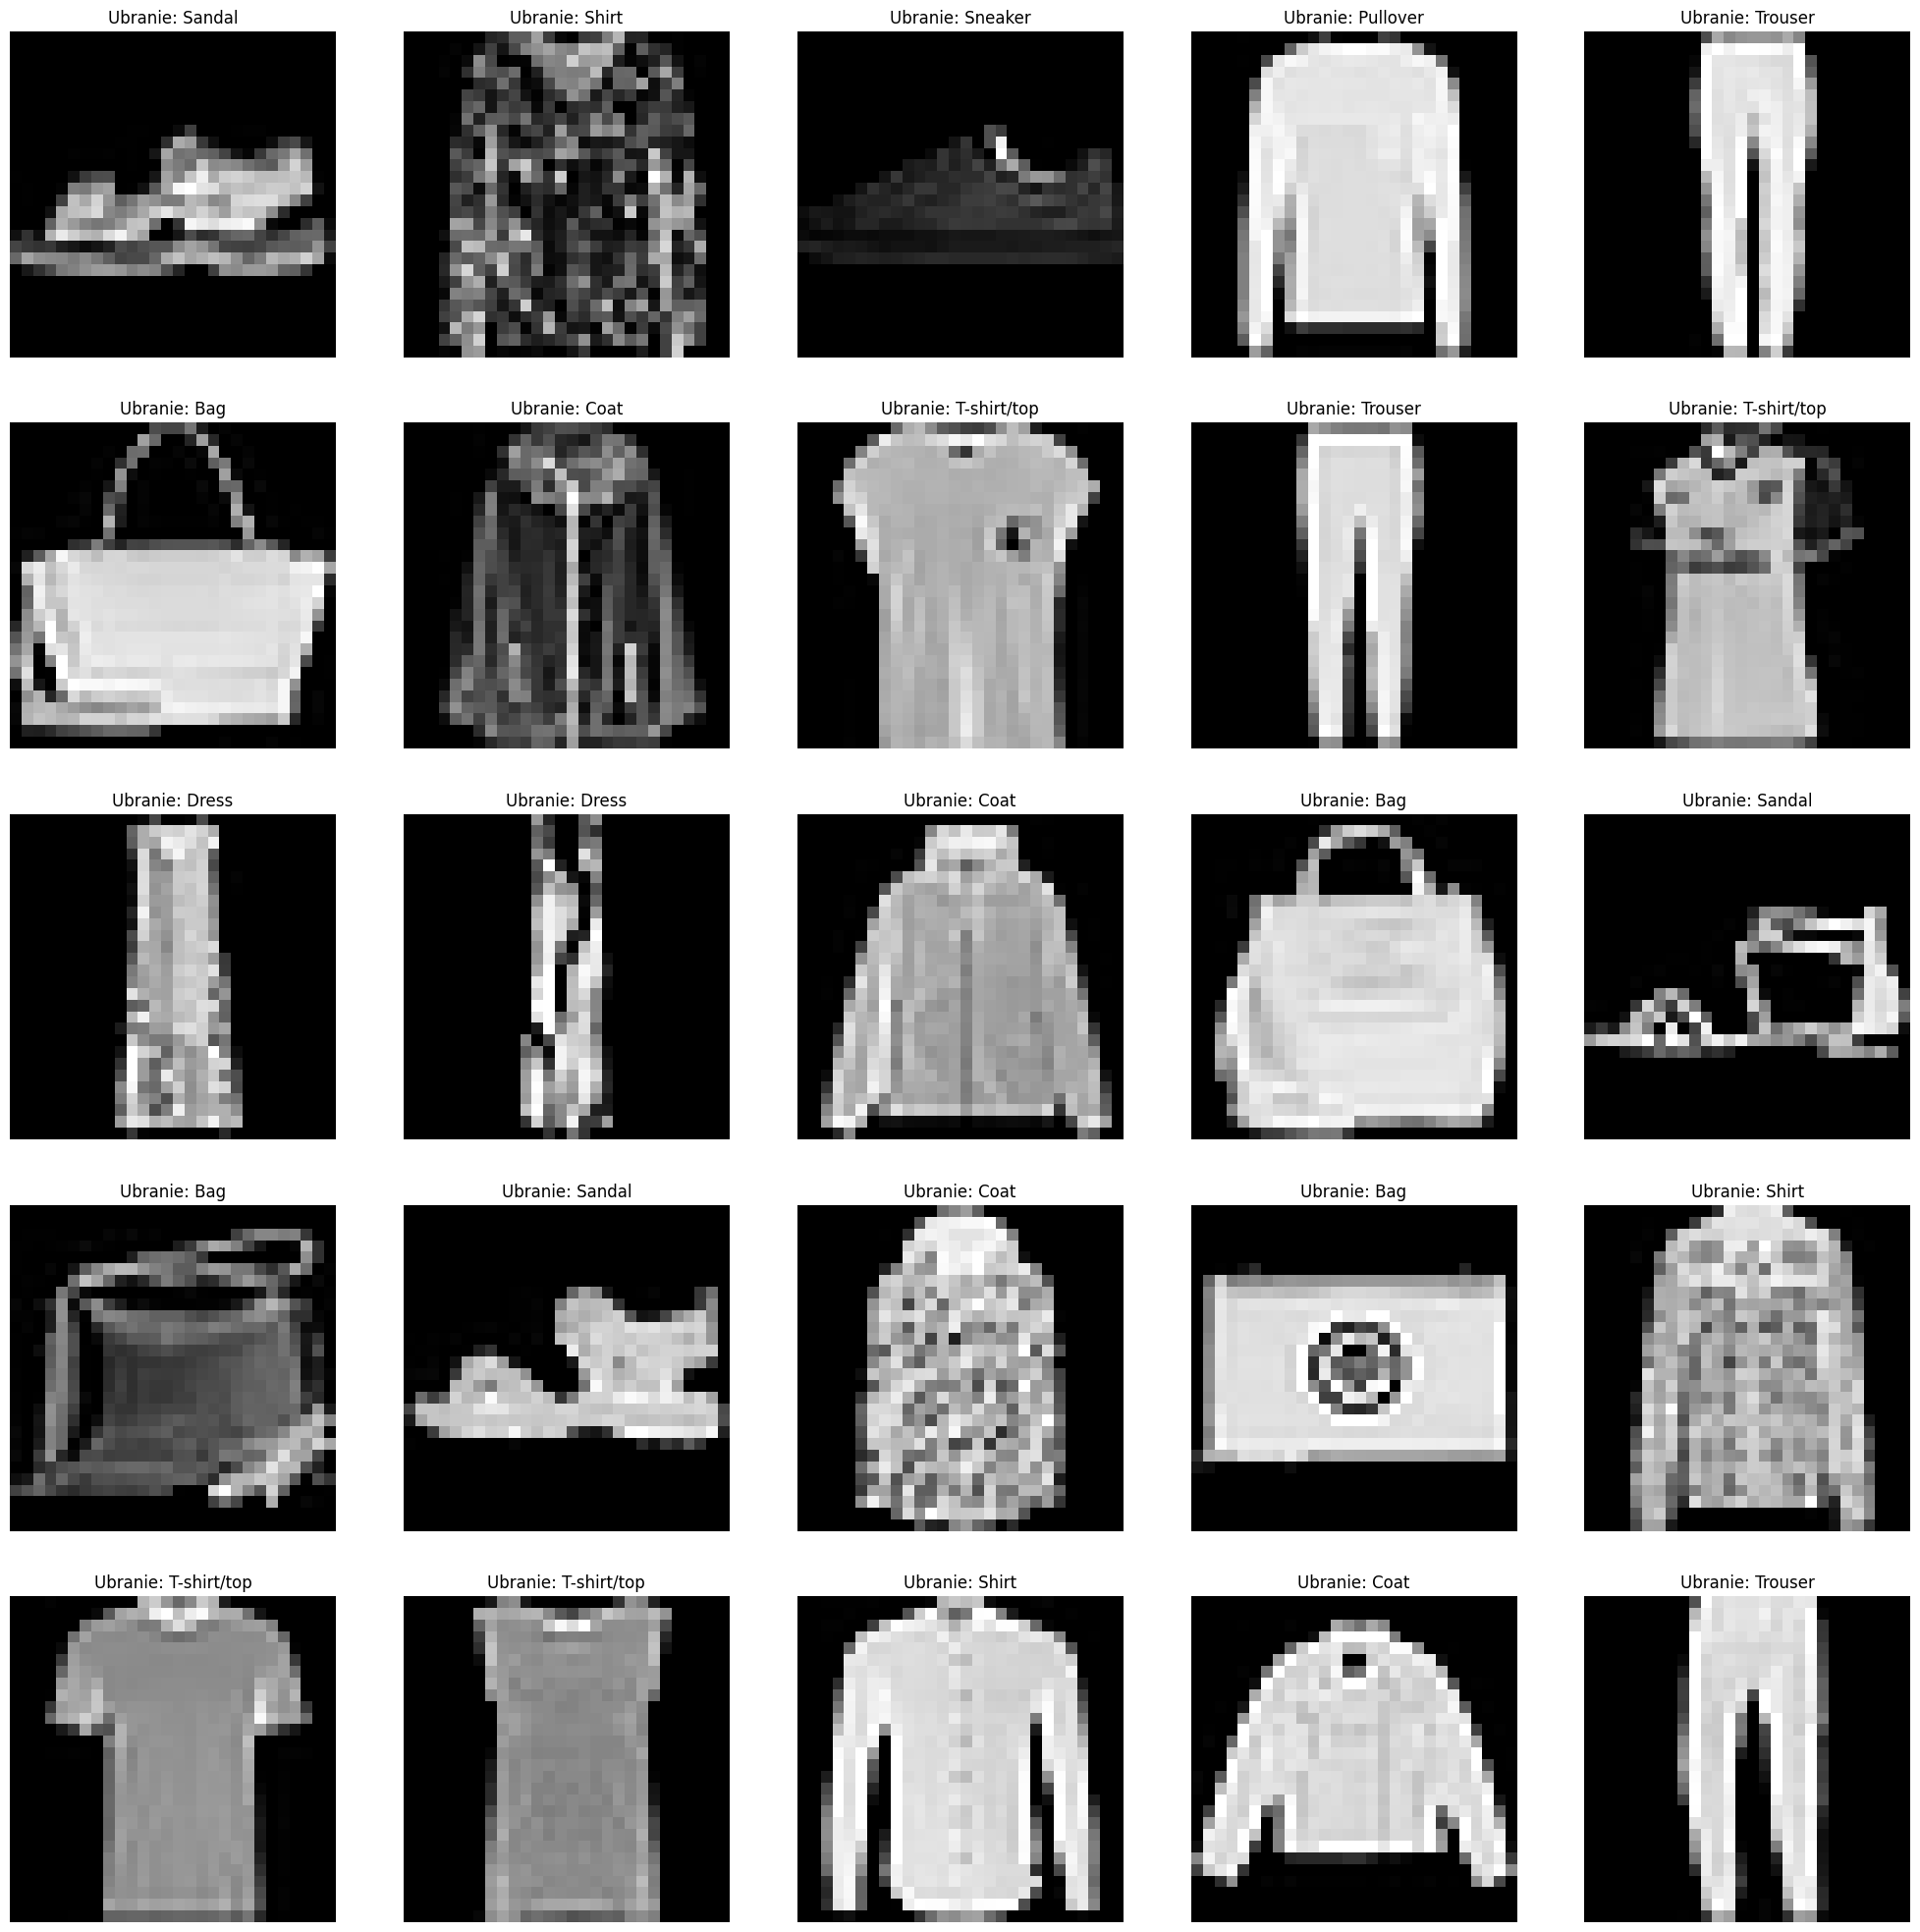

In [3]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
gridSize = 5

fig, axes = plt.subplots(gridSize, gridSize, figsize=(25, 25))
axes = axes.ravel()

for i in range(gridSize ** 2):
    drafted_image = np.random.randint(0, x_test.shape[0])
    axes[i].imshow(x_test[drafted_image], cmap='gray')
    axes[i].set_title(f"Ubranie: {labels[y_test[drafted_image]]}")
    axes[i].axis('off')

Warstwa konwolucyjna wymaga aby dane miały kształt w formacie **(width, height, channels)**. W związku z tym dodaje dodatkowy wymiar do  zbioru treningowego i testowego wykorzystując **np.expand_dims()**.

Dodatkowo normalizuję dane, aby polepszyć trening sieci.

In [4]:
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

## Trening modelu

Model składa się z dwóch warstw konwolucyjnych. Po każdej warstwie znajdują się warstwy redukcyjne, które zmniejszają rozmiar map cech.
Każda warstwa Conv2D wykorzystuje filtr o rozmiarach 3x3 i domyślnym stride 1x1.

Pierwsza warstwa nie posiada paddingu (ustawienie domyślne), jednak ma zdefiniowany dilatation_rate.
Druga warstwa ma więcej filtrów i stosuje padding.

Obie warstwy mają zdefiniowaną funkcje aktywacji **ReLU**.

Dodatkowo dane trafiają do warstw gęstych. Pierwsza z nich ma ustawiony **Dropout**, która zapobiega przetrenowaniu modelu.

In [5]:
model = Sequential([
    Input(shape=x_train[0].shape),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', dilation_rate=2),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    AveragePooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 6, 6, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,242 (309.54 KB)

 Trainable params: 79,242 (309.54 KB)

 Non-trainable params: 0 (0.00 B)

Optymalizatorem modelu jest **Adam**, z krokiem początkowym ustawionym na 0.01.

In [6]:
model.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8144 - loss: 0.5026 - val_accuracy: 0.8590 - val_loss: 0.3898
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8592 - loss: 0.3854 - val_accuracy: 0.8683 - val_loss: 0.3836
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8665 - loss: 0.3634 - val_accuracy: 0.8790 - val_loss: 0.3413


## Mierzenie skuteczności modelu

Do obliczenia podstawowych metryk wykorzystuję **classification_report** z biblioteki scikit-learn.

In [7]:
y_pred = model.predict(x_test)
y_label = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_label, target_names=labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.80      0.80      0.80      1000
       Dress       0.89      0.88      0.88      1000
        Coat       0.77      0.79      0.78      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.69      0.62      0.65      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

